# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [17:48:36.211] [88658] 151 logging_/<module>: {logging_yaml: None}

INFO     [17:48:36.680] [88658]  36 api.server_globals/init

DEBUG    [17:48:36.687] [88658]  84 api.server_globals/load: load_search...

INFO     [17:48:37.027] [88658]  88 api.server_globals/load: load_search (took 0.332s)

DEBUG    [17:48:37.033] [88658]  84 api.server_globals/load: load_xc_meta...

INFO     [17:48:37.422] [88658]  88 api.server_globals/load: load_xc_meta (took 0.383s)

DEBUG    [17:48:37.429] [88658]  84 api.server_globals/load: load_feat_info...

INFO     [17:48:37.437] [88658] 120 api.server_globals/load_feat_info

INFO     [17:48:37.443] [88658]  88 api.server_globals/load: load_feat_info (took 0.006s)

WARNING  [17:48:37.449] [88658]  82 api.server_globals/load: load_search_recs [skipped]

INFO     [17:48:37.455] [88658]  38 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

In [ ]:
# Fail if too few recs are downloaded (easy way to waste a bunch of training time!)
sg_load.load_xc_meta(_nocache=True,
    fail_on_low_download_frac=True,
);

INFO     [17:48:37.648] [88658] 104 api.server_globals/load_xc_meta

all              9442/399859 (sp/recs)

countries         1148/59713 (sp/recs)

species            334/35237 (sp/recs)

(downloaded)       334/35233 (sp/recs)

 99.99%

recs_at_least      334/35233 (sp/recs)

num_species        334/35233 (sp/recs)

num_recs           334/35233 (sp/recs)

recs ≥ 2           334/35233 (sp/recs)

search_recs(**{'cache_type': 'hybrid'})

INFO     [17:48:43.235] [88658] 602 api.recs/get_search_recs

INFO     [17:48:43.245] [88658] 152 payloads/df_cache_hybrid: Hit: payloads/search_recs-audio_s[10],version[8],com_names_k[ca],countries_k[na],num_recs[None]-c292d6b

INFO     [17:48:45.067] [88658] 169 payloads/df_cache_hybrid: Hit: Read api/lite.parquet (51.0 MB) [1.805s]

INFO     [17:48:52.664] [88658] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-audio_bytes.parquet (1.4 GB) [7.577s]

INFO     [17:48:53.582] [88658] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-spectro_bytes.parquet (382.8 MB) [0.845s]

INFO     [17:48:53.637] [88658] 188 payloads/df_cache_hybrid: Hit: Read api/feat-f_preds.npy (46.6 MB) [float32, 0.041s]

INFO     [17:48:53.793] [88658] 188 payloads/df_cache_hybrid: Hit: Read api/feat-feat.npy (211.4 MB) [float32, 0.145s]

INFO     [17:48:53.800] [88658] 191 payloads/df_cache_hybrid: Hit: Join lite + bytes + feats

INFO     [17:48:54.395] [88658] 202 payloads/df_cache_hybrid: Hit [11.137s]

INFO     [17:48:55.917] [88658] 246 payloads/df_cache_hybrid: Mobile: Add columns for mobile [1.505s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (334) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

##############################################################

] | 100% (334) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.0s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.2s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.3s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.4s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.5s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.6s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.7s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.8s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.9s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.0s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.1s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.3s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.4s

Mobile: Write files: audio_bytes: [

#######                                                     

] |  12% (35231) |  1.5s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  1.6s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  1.7s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  1.8s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  1.9s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.0s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.1s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.2s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.3s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.4s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.5s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.6s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.7s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  2.9s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  3.0s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  16% (35231) |  3.1s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.2s

Mobile: Write files: audio_bytes: [

#################                                           

] |  29% (35231) |  3.3s

Mobile: Write files: audio_bytes: [

#################                                           

] |  29% (35231) |  3.4s

Mobile: Write files: audio_bytes: [

##################                                          

] |  31% (35231) |  3.5s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  3.6s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  3.7s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  3.8s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  3.9s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.0s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.1s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.2s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.4s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.5s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.6s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.7s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.8s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.9s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  5.0s

Mobile: Write files: audio_bytes: [

#######################                                     

] |  39% (35231) |  5.1s

Mobile: Write files: audio_bytes: [

###########################                                 

] |  45% (35231) |  5.2s

Mobile: Write files: audio_bytes: [

###########################                                 

] |  45% (35231) |  5.3s

Mobile: Write files: audio_bytes: [

############################                                

] |  47% (35231) |  5.4s

Mobile: Write files: audio_bytes: [

############################                                

] |  47% (35231) |  5.5s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  5.6s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  5.8s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  5.9s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  6.0s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  6.1s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  6.2s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  6.3s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  6.5s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  6.6s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  6.7s

Mobile: Write files: audio_bytes: [

#################################                           

] |  56% (35231) |  6.8s

Mobile: Write files: audio_bytes: [

###################################                         

] |  58% (35231) |  6.9s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.0s

Mobile: Write files: audio_bytes: [

#####################################                       

] |  62% (35231) |  7.1s

Mobile: Write files: audio_bytes: [

######################################                      

] |  64% (35231) |  7.2s

Mobile: Write files: audio_bytes: [

######################################                      

] |  64% (35231) |  7.3s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  7.4s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  7.5s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  7.7s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  7.8s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  7.9s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.0s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.1s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.2s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.3s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.4s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.5s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.6s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.7s

Mobile: Write files: audio_bytes: [

#########################################                   

] |  68% (35231) |  8.8s

Mobile: Write files: audio_bytes: [

#############################################               

] |  75% (35231) |  8.9s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) |  9.0s

Mobile: Write files: audio_bytes: [

###############################################             

] |  79% (35231) |  9.2s

Mobile: Write files: audio_bytes: [

################################################            

] |  81% (35231) |  9.3s

Mobile: Write files: audio_bytes: [

##################################################          

] |  83% (35231) |  9.4s

Mobile: Write files: audio_bytes: [

##################################################          

] |  83% (35231) |  9.5s

Mobile: Write files: audio_bytes: [

##################################################          

] |  83% (35231) |  9.6s

Mobile: Write files: audio_bytes: [

##################################################          

] |  83% (35231) |  9.7s

Mobile: Write files: audio_bytes: [

##################################################          

] |  83% (35231) |  9.8s

Mobile: Write files: audio_bytes: [

##################################################          

] |  83% (35231) |  9.9s

Mobile: Write files: audio_bytes: [

##################################################          

] |  83% (35231) | 10.0s

Mobile: Write files: audio_bytes: [

####################################################        

] |  87% (35231) | 10.1s

Mobile: Write files: audio_bytes: [

########################################################    

] |  93% (35231) | 10.2s

Mobile: Write files: audio_bytes: [

############################################################

] | 100% (35231) | 10.4s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (334) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

############################################################

] | 100% (334) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.2s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.3s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.4s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.5s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.6s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.7s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.8s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.1s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.2s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.3s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.4s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.5s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  1.6s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  1.7s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  1.8s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  1.9s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.0s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.2s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.3s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.4s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.5s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.6s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.7s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.8s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.9s

Mobile: Write files: spectro_bytes: [

##################                                        

] |  31% (35231) |  3.0s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.1s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.2s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.4s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.5s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.6s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.7s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.8s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.9s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.0s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.1s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.2s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.3s

Mobile: Write files: spectro_bytes: [

##############################                            

] |  52% (35231) |  4.4s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  4.6s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  4.7s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  4.8s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  4.9s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.0s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.1s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.2s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.3s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.4s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.6s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.7s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.8s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.9s

Mobile: Write files: spectro_bytes: [

#######################################                   

] |  67% (35231) |  6.0s

Mobile: Write files: spectro_bytes: [

############################################              

] |  77% (35231) |  6.1s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.2s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.3s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.4s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.5s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.7s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.8s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.9s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.0s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.1s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.2s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.3s

Mobile: Write files: spectro_bytes: [

###############################################           

] |  82% (35231) |  7.4s

Mobile: Write files: spectro_bytes: [

##########################################################

] | 100% (35231) |  7.5s

INFO     [17:49:35.029] [88658] 288 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (331) [6.046s]

INFO     [17:49:35.430] [88658] 300 payloads/df_cache_hybrid: Mobile: Norm feat col: f_preds [0.385s]

INFO     [17:49:35.805] [88658] 331 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (35231) [0.166s]

INFO     [17:49:35.976] [88658] 331 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (35231) [0.158s]

INFO     [17:49:59.829] [88658] 353 payloads/df_cache_hybrid: Mobile: Create table search_recs [166.2 MB, 23.764s]

INFO     [17:50:00.012] [88658] 387 payloads/df_cache_hybrid: Mobile: Create index (source_id) [602.1 kB, 0.171s]

INFO     [17:50:00.210] [88658] 387 payloads/df_cache_hybrid: Mobile: Create index (species, source_id) [786.4 kB, 0.184s]

INFO     [17:50:00.430] [88658] 387 payloads/df_cache_hybrid: Mobile: Create index (species, species_species_group, quality, source_id) [1.6 MB, 0.206s]

INFO     [17:50:00.650] [88658] 387 payloads/df_cache_hybrid: Mobile: Create index (species_species_group, species, quality, source_id) [1.6 MB, 0.208s]

INFO     [17:50:01.129] [88658] 390 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/search_recs.sqlite3 [170.7 MB, 25.080s]

INFO     [17:50:01.146] [88658] 399 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/server-config.json [2.3 kB, 0.001s]

INFO     [17:50:01.689] [88658] 415 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/metadata/species.json [4.8 MB, 0.533s]

INFO     [17:50:01.709] [88658] 436 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.D.npy [420.1 kB, 0.005s]

INFO     [17:50:01.723] [88658] 436 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.mean_.npy [1.4 kB, 0.001s]

INFO     [17:50:01.736] [88658] 436 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.components_.npy [134.5 kB, 0.001s]

INFO     [17:50:01.750] [88658] 436 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.explained_variance_.npy [968 B, 0.002s]

INFO     [17:50:01.779] [88658] 436 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/classifier_._coef_arr.npy [4.0 MB, 0.006s]

INFO     [17:50:01.799] [88658] 436 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/classifier_._intercept_arr.npy [2.8 kB, 0.001s]

INFO     [17:50:01.805] [88658] 490 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/models/search.json [4.9 kB, 0.105s]

INFO     [17:50:01.811] [88658] 490 payloads/df_cache_hybrid: Mobile: Write payload [67.404s]

,dir,file,size,frac
5,api,TOTAL,2104303182,1.000
1,api,api/bytes-audio_bytes.parquet,1412454635,0.671
2,api,api/bytes-spectro_bytes.parquet,382830165,0.182
4,api,api/feat-feat.npy: float32,211386128,0.100
0,api,api/lite.parquet,50986282,0.024
3,api,api/feat-f_preds.npy: float32,46645972,0.022
9,mobile-version[2],TOTAL,2121449472,1.000
6,mobile-version[2],mobile-version[2]/search_recs/audio/,1502609408,0.708
7,mobile-version[2],mobile-version[2]/search_recs/spectro/,449687552,0.212
8,mobile-version[2],mobile-version[2]/search_recs/search_recs.sqlite3,169152512,0.080


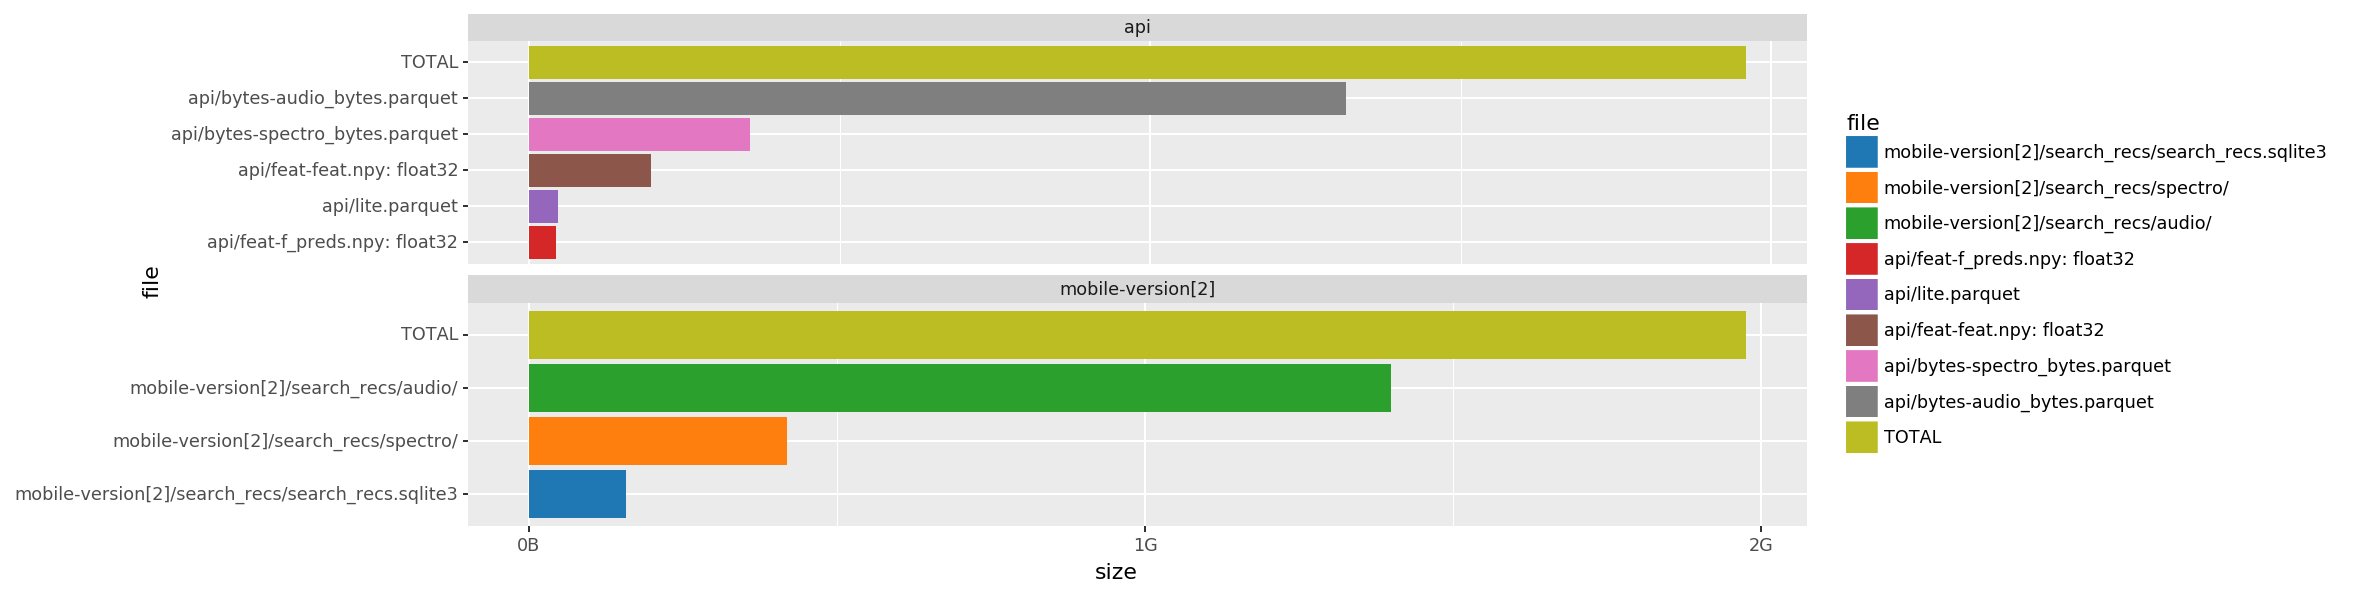

<ggplot: (423434465)>

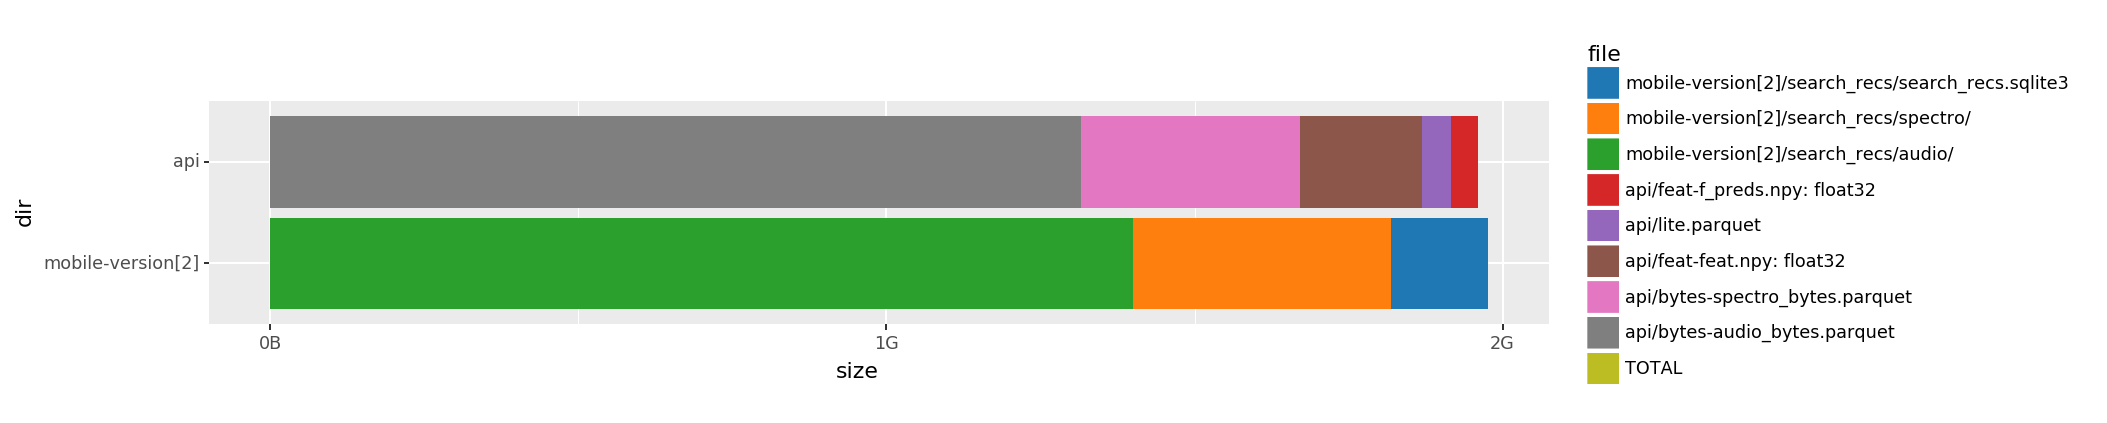

<ggplot: (-9223372036508250396)>

,size,type,0
xc_id,36,int,413174
feat,104,ndarray,[ 9.373e-02 -4.262e-02 4.967e-01 1.976e-03 -5.053e-02 -5.996e-02 4.511e-02 -1.633e-01 6.422e-02 -2.063e-02 -7.629e-02 -8.226e-02 -9.336e-02 5.237e-02 -4.327e-02 -7.05...
f_preds,104,ndarray,[3.219e-03 1.693e-03 4.284e-05 3.685e-03 1.657e-03 1.457e-02 9.939e-03 1.444e-03 2.617e-04 6.943e-04 4.435e-04 7.072e-04 2.569e-03 9.745e-03 8.396e-04 2.003e-03 7.801e-04 ...
background,80,list,['White-crowned Sparrow (Zonotrichia leucophrys)']
background_species,80,list,['WCSP']


In [ ]:
with ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # XXX Debug
    log_levels({
        'payloads': 'INFO',
        # 'payloads': 'DEBUG',
    })
    kwargss = [
        # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss [XXX Debug]
        dict(cache_type='hybrid'),                  # Allow cache hit
    ]
    search_recss = []
    for i, kwargs in enumerate(kwargss):
        if i > 0: print()
        print(f'search_recs(**{kwargs})')
        get_search_recs.cache_clear()
        search_recs = get_search_recs(**kwargs,
            write_mobile_payload=True,
            plot_sizes=True,
        )
        search_recss.append(search_recs)
        display(search_recs
            [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
            [2:3].reset_index(drop=True).T
            .pipe(df_assign_first,
                size=lambda df: df.T.memory_usage(deep=True),
                type=lambda df: df[0].map(lambda x: type(x).__name__),
            )
        )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)

[skip]